In [1]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# Read

In [2]:
dirpath = os.path.join(Path.home(), "FjordsSim_data", "sognefjord")
ds = xr.open_dataset(os.path.join(dirpath, "sogn800LL_2018.nc"))

In [3]:
ds["depth"] = -ds.depth

In [4]:
ds = ds.rename({"Ix": "Nx", "Jy": "Ny", "depth": "Nz", "temp": "T", "salt": "S", "U": "u", "V": "v"})

In [1]:
# BUGS here, do not work
xrivers = [235, 228, 197, 170]
yrivers = [83, 119, 32, 100]

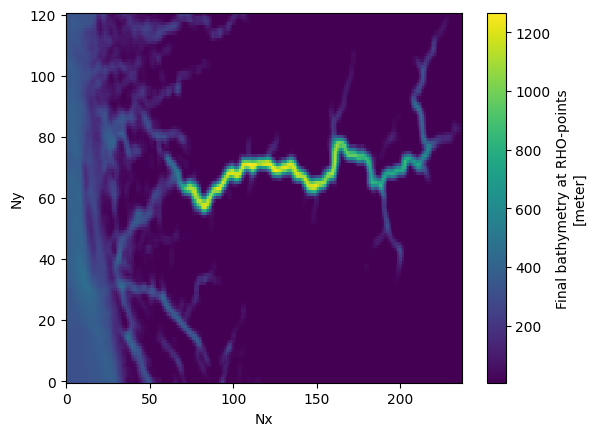

In [6]:
ds.h.plot()

# Interpolate on z-centers

In [15]:
z_faces = [
      -1200.0,
      -1000.0,
      -800.0,
      -600.0,
      -500.0,
      -400.0,
      -300.0,
      -200.0,
      -150.0,
      -100.0,
      -75.0,
      -50.0,
      -30.0,
      -20.0,
      -10.0,
       -5.0,
        0.0
]

In [16]:
z_centers = [(z_faces[i] + z_faces[i+1]) / 2 for i in range(len(z_faces) - 1)]

In [17]:
z_centers

[-1100.0,
 -900.0,
 -700.0,
 -550.0,
 -450.0,
 -350.0,
 -250.0,
 -175.0,
 -125.0,
 -87.5,
 -62.5,
 -40.0,
 -25.0,
 -15.0,
 -7.5,
 -2.5]

In [18]:
ds = ds.interp(Nz=z_centers)

In [19]:
ds

<xarray.Dataset> Size: 5GB
Dimensions:   (Ny: 121, Nx: 238, time: 334, Nz: 16)
Coordinates:
  * time      (time) datetime64[ns] 3kB 2018-01-01T12:00:00 ... 2018-12-30T12...
  * Nz        (Nz) float64 128B -1.1e+03 -900.0 -700.0 ... -15.0 -7.5 -2.5
Dimensions without coordinates: Ny, Nx
Data variables:
    lat       (Ny, Nx) float64 230kB 60.63 60.63 60.63 60.63 ... 61.5 61.5 61.5
    lon       (Ny, Nx) float64 230kB 4.186 4.201 4.216 ... 7.688 7.702 7.717
    h         (Ny, Nx) float64 230kB 309.6 310.5 312.0 312.3 ... 5.0 5.0 5.0 5.0
    mask_rho  (Ny, Nx) float64 230kB 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
    T         (time, Nz, Ny, Nx) float64 1GB nan nan nan nan ... nan nan nan nan
    S         (time, Nz, Ny, Nx) float64 1GB nan nan nan nan ... nan nan nan nan
    u         (time, Nz, Ny, Nx) float64 1GB 9.969e+36 9.969e+36 ... 9.969e+36
    v         (time, Nz, Ny, Nx) float64 1GB 9.969e+36 9.969e+36 ... 9.969e+36
Attributes:
    history:  Created 12.11.2024 by ans@niva.no\nEdited  21.11.2024 by ans@ni...

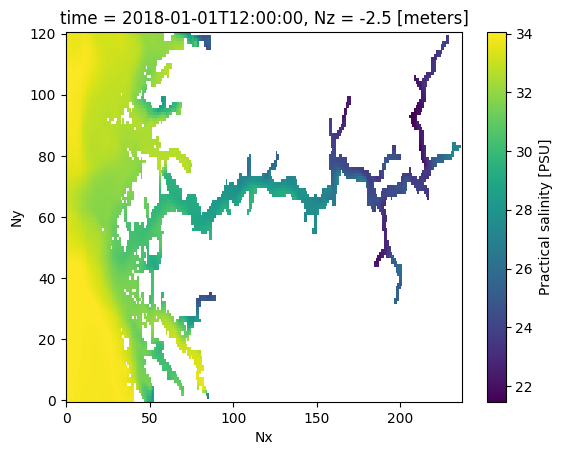

In [20]:
ds.S.isel(time=0).isel(Nz=-1).plot()

# T, S

In [21]:
T_lambda_data = np.full(ds.T.shape, -999, dtype=np.float32)
T_lambda_data[:, :, :, :] = 1 / 60 / 60 / 24 / 20
T_lambda_da = xr.DataArray(
    T_lambda_data,
    dims=("time", "Nz", "Ny", "Nx"),
    coords={dim: ds.coords[dim] for dim in ["time", "Nz", "Ny", "Nx"]},  # Copy coords
    name="T_lambda"
)
ds["T_lambda"] = T_lambda_da

In [22]:
S_lambda_data = np.full(ds.S.shape, -999, dtype=np.float32)
S_lambda_data[:, :, :, :] = 1 / 60 / 60 / 24 / 20
S_lambda_da = xr.DataArray(
    S_lambda_data,
    dims=("time", "Nz", "Ny", "Nx"),
    coords={dim: ds.coords[dim] for dim in ["time", "Nz", "Ny", "Nx"]},  # Copy coords
    name="S_lambda"
)
ds["S_lambda"] = S_lambda_da

In [23]:
ds["T"] = ds["T"].astype(np.float32)
ds["S"] = ds["S"].astype(np.float32)

In [24]:
mask = np.zeros_like(ds["T"], dtype=bool)
mask[:, :, [0, -1], :] = True
mask[:, :, :, [1, -1]] = True

In [25]:
ds["T"] = xr.where(mask, ds["T"], np.nan)
ds["T_lambda"] = xr.where(mask, ds["T_lambda"], np.nan)
ds["S"] = xr.where(mask, ds["S"], np.nan)
ds["S_lambda"] = xr.where(mask, ds["S_lambda"], np.nan)

# u, v

In [26]:
for x, y in zip(xrivers, yrivers):
    ds["S"].values[:,:,y,x] = 0
    ds["S"].values[:,:,y,x] = 0

In [27]:
Nt, Nz, Ny, Nx = ds["T"].shape

In [28]:
Uout = np.full((Nt, Nz, Ny, Nx + 1), 0, dtype=np.float32)
Uout_lambda = np.full((Nt, Nz, Ny, Nx + 1), 1 / 60 / 60 / 24 / 20, dtype=np.float32)
Vout = np.full((Nt, Nz, Ny + 1, Nx), 0.05, dtype=np.float32)
Vout_lambda = np.full((Nt, Nz, Ny + 1, Nx), 1 / 60 / 60 / 24 / 20, dtype=np.float32)

Uout[:,:-6,:,:] = np.nan
Vout[:,:-6,:,:] = np.nan
Uout_lambda[:,:-6,:,:] = np.nan
Vout_lambda[:,:-6,:,:] = np.nan

In [29]:
lons_faces = np.linspace(4.186, 7.717, Nx + 1)
lats_faces = np.linspace(60.63, 61.5, Ny + 1)

In [30]:
ds.coords["Nx_faces"] = ("Nx_faces", lons_faces)
ds.coords["Ny_faces"] = ("Ny_faces", lats_faces)

ds["u"] = xr.DataArray(
    Uout,
    dims=("time", "Nz", "Ny", "Nx_faces"),
    coords={dim: ds.coords[dim] for dim in ["time", "Nz", "Ny", "Nx_faces"]},  # Copy coords
    name="u"
)

ds["v"] = xr.DataArray(
    Vout,
    dims=("time", "Nz", "Ny_faces", "Nx"),
    coords={dim: ds.coords[dim] for dim in ["time", "Nz", "Ny_faces", "Nx"]},  # Copy coords
    name="v"
)

ds["u_lambda"] = xr.DataArray(
    Uout_lambda,
    dims=("time", "Nz", "Ny", "Nx_faces"),
    coords={dim: ds.coords[dim] for dim in ["time", "Nz", "Ny", "Nx_faces"]},  # Copy coords
    name="u_lambda"
)

ds["v_lambda"] = xr.DataArray(
    Vout_lambda,
    dims=("time", "Nz", "Ny_faces", "Nx"),
    coords={dim: ds.coords[dim] for dim in ["time", "Nz", "Ny_faces", "Nx"]},  # Copy coords
    name="v_lambda"
)

In [31]:
ds

<xarray.Dataset> Size: 5GB
Dimensions:   (Ny: 121, Nx: 238, time: 334, Nz: 16, Nx_faces: 239, Ny_faces: 122)
Coordinates:
  * time      (time) datetime64[ns] 3kB 2018-01-01T12:00:00 ... 2018-12-30T12...
  * Nz        (Nz) float64 128B -1.1e+03 -900.0 -700.0 ... -15.0 -7.5 -2.5
  * Ny        (Ny) int64 968B 0 1 2 3 4 5 6 7 ... 114 115 116 117 118 119 120
  * Nx        (Nx) int64 2kB 0 1 2 3 4 5 6 7 ... 230 231 232 233 234 235 236 237
  * Nx_faces  (Nx_faces) float64 2kB 4.186 4.201 4.216 ... 7.687 7.702 7.717
  * Ny_faces  (Ny_faces) float64 976B 60.63 60.64 60.64 ... 61.49 61.49 61.5
Data variables:
    lat       (Ny, Nx) float64 230kB 60.63 60.63 60.63 60.63 ... 61.5 61.5 61.5
    lon       (Ny, Nx) float64 230kB 4.186 4.201 4.216 ... 7.688 7.702 7.717
    h         (Ny, Nx) float64 230kB 309.6 310.5 312.0 312.3 ... 5.0 5.0 5.0 5.0
    mask_rho  (Ny, Nx) float64 230kB 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
    T         (time, Nz, Ny, Nx) float32 616MB nan nan nan nan ... nan nan nan
    S         (time, Nz, Ny, Nx) float32 616MB nan nan nan nan ... nan nan nan
    u         (time, Nz, Ny, Nx_faces) float32 618MB nan nan nan ... 0.0 0.0 0.0
    v         (time, Nz, Ny_faces, Nx) float32 621MB nan nan nan ... 0.05 0.05
    T_lambda  (time, Nz, Ny, Nx) float32 616MB 5.787e-07 5.787e-07 ... 5.787e-07
    S_lambda  (time, Nz, Ny, Nx) float32 616MB 5.787e-07 5.787e-07 ... 5.787e-07
    u_lambda  (time, Nz, Ny, Nx_faces) float32 618MB nan nan ... 5.787e-07
    v_lambda  (time, Nz, Ny_faces, Nx) float32 621MB nan nan ... 5.787e-07
Attributes:
    history:  Created 12.11.2024 by ans@niva.no\nEdited  21.11.2024 by ans@ni...

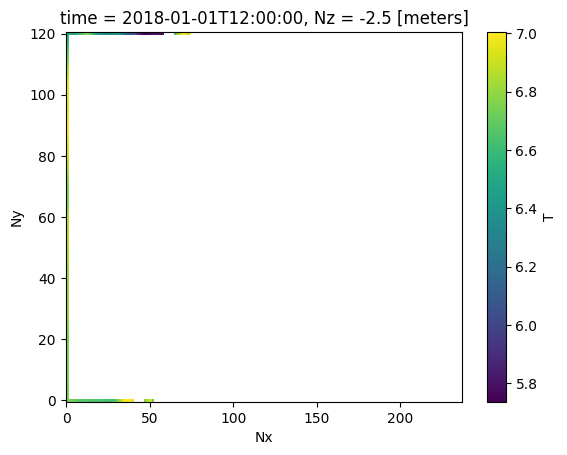

In [32]:
ds.T.isel(time=0, Nz=-1).plot()

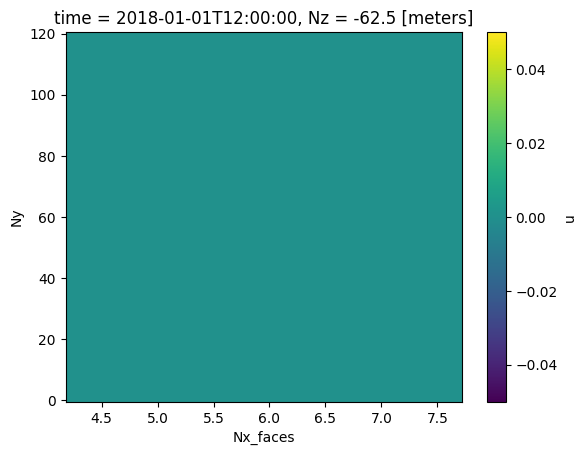

In [33]:
ds.u.isel(time=0, Nz=-6).plot()

In [34]:
ds = ds.fillna(-999)

In [35]:
ds

<xarray.Dataset> Size: 5GB
Dimensions:   (Ny: 121, Nx: 238, time: 334, Nz: 16, Nx_faces: 239, Ny_faces: 122)
Coordinates:
  * time      (time) datetime64[ns] 3kB 2018-01-01T12:00:00 ... 2018-12-30T12...
  * Nz        (Nz) float64 128B -1.1e+03 -900.0 -700.0 ... -15.0 -7.5 -2.5
  * Ny        (Ny) int64 968B 0 1 2 3 4 5 6 7 ... 114 115 116 117 118 119 120
  * Nx        (Nx) int64 2kB 0 1 2 3 4 5 6 7 ... 230 231 232 233 234 235 236 237
  * Nx_faces  (Nx_faces) float64 2kB 4.186 4.201 4.216 ... 7.687 7.702 7.717
  * Ny_faces  (Ny_faces) float64 976B 60.63 60.64 60.64 ... 61.49 61.49 61.5
Data variables:
    lat       (Ny, Nx) float64 230kB 60.63 60.63 60.63 60.63 ... 61.5 61.5 61.5
    lon       (Ny, Nx) float64 230kB 4.186 4.201 4.216 ... 7.688 7.702 7.717
    h         (Ny, Nx) float64 230kB 309.6 310.5 312.0 312.3 ... 5.0 5.0 5.0 5.0
    mask_rho  (Ny, Nx) float64 230kB 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
    T         (time, Nz, Ny, Nx) float32 616MB -999.0 -999.0 ... -999.0 -999.0
    S         (time, Nz, Ny, Nx) float32 616MB -999.0 -999.0 ... -999.0 -999.0
    u         (time, Nz, Ny, Nx_faces) float32 618MB -999.0 -999.0 ... 0.0 0.0
    v         (time, Nz, Ny_faces, Nx) float32 621MB -999.0 -999.0 ... 0.05 0.05
    T_lambda  (time, Nz, Ny, Nx) float32 616MB 5.787e-07 5.787e-07 ... 5.787e-07
    S_lambda  (time, Nz, Ny, Nx) float32 616MB 5.787e-07 5.787e-07 ... 5.787e-07
    u_lambda  (time, Nz, Ny, Nx_faces) float32 618MB -999.0 -999.0 ... 5.787e-07
    v_lambda  (time, Nz, Ny_faces, Nx) float32 621MB -999.0 -999.0 ... 5.787e-07
Attributes:
    history:  Created 12.11.2024 by ans@niva.no\nEdited  21.11.2024 by ans@ni...

In [36]:
outvars = ["time", "T", "T_lambda", "S", "S_lambda", "u", "u_lambda", "v", "v_lambda"]

In [37]:
ds[outvars].to_netcdf(os.path.join(dirpath, "Sogn_bry800.nc"))

In [52]:
ds[["time", "T", "T_lambda", "S", "S_lambda"]]

<xarray.Dataset> Size: 2GB
Dimensions:   (time: 334, Nz: 16, Ny: 121, Nx: 238)
Coordinates:
  * time      (time) datetime64[ns] 3kB 2018-01-01T12:00:00 ... 2018-12-30T12...
  * Nz        (Nz) float64 128B -1.1e+03 -900.0 -700.0 ... -15.0 -7.5 -2.5
  * Ny        (Ny) int64 968B 0 1 2 3 4 5 6 7 ... 114 115 116 117 118 119 120
  * Nx        (Nx) int64 2kB 0 1 2 3 4 5 6 7 ... 230 231 232 233 234 235 236 237
Data variables:
    T         (time, Nz, Ny, Nx) float32 616MB -999.0 -999.0 ... -999.0 -999.0
    T_lambda  (time, Nz, Ny, Nx) float32 616MB 5.787e-07 5.787e-07 ... 5.787e-07
    S         (time, Nz, Ny, Nx) float32 616MB -999.0 -999.0 ... -999.0 -999.0
    S_lambda  (time, Nz, Ny, Nx) float32 616MB 5.787e-07 5.787e-07 ... 5.787e-07
Attributes:
    history:  Created 12.11.2024 by ans@niva.no\nEdited  21.11.2024 by ans@ni...